This notebook describes the details of forming the coefficient matrix and ordinate vector from walking data for a linear least squares solution to the optimal gains from a simple full state feedback controller employed by the human while walking.

In [1]:
from sympy import init_printing, symbols, Matrix, Symbol, zeros, eye

In [2]:
init_printing(print_builtin=False)

In [3]:
n = 3 # number of time samples in each gait cycle
m = 2 # number of gait cycles
p = 2 # number of sensors
q = 2 # number of controls

First form the equation that generates the controls given the error in the sensors at a single time step during a single foot step.

$$
\begin{align}
  \mathbf{m}(t) & = & \mathbf{m}_0(\varphi) + \mathbf{K}(\varphi) \mathbf{s}_e(t) \\
  & = & \mathbf{m}_0(\varphi) + \mathbf{K}(\varphi) [\mathbf{s}_0(\varphi) - \mathbf{s}(t)] 
\end{align}
$$

Now rearrange the equations such that we have one linear in both the gains, $\mathbf{K}(\varphi)$, and in $\mathbf{m}^*(\varphi)$:

$$
\begin{align}
  \mathbf{m}(t) & = & \mathbf{m}_0(\varphi) + \mathbf{K}(\varphi) \mathbf{s}_0(\varphi) - \mathbf{K}(\varphi) \mathbf{s}(t) \\
  & = & \mathbf{m}^*(\varphi) - \mathbf{K}(\varphi) \mathbf{s}(t)
\end{align}
$$

The "measured" controls, $\mathbf{m}(t)$:

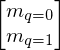

In [4]:
m = Matrix(q, 1, lambda i, j: Symbol('m_q={}'.format(i)))
m

The unknown gains, $\mathbf{K}(\varphi)$:

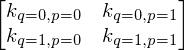

In [5]:
K = Matrix(q, p, lambda i, j: Symbol('k_q={},p={}'.format(i, j)))
K

The unknown nominal controls, $\mathbf{m}^*(\varphi)$:

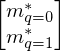

In [6]:
ms = Matrix(q, 1, lambda i, j: Symbol('m^*_q={}'.format(i)))
ms

The measured sensors, $\mathbf{s}(t)$:

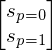

In [7]:
s = Matrix(p, 1, lambda i, j: Symbol('s_p={}'.format(i)))
s

And the equation:

$$\mathbf{0} = \mathbf{m}^*(\varphi) - \mathbf{K}(\varphi) \mathbf{s}(t) - \mathbf{m}(t)$$

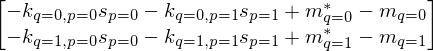

In [8]:
zero = ms - K * s - m
zero

Now for a simple linear least squares the equations can be massage into this form:

$$\mathbf{Ax}=\mathbf{b}$$

which, for large $m$, gives and over determined system of linear equations.

We define $\mathbf{x}$ as:


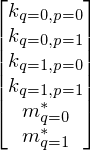

In [9]:
x = K.reshape(q * p, 1).col_join(ms)
x

To form the $\mathbf{A}$ matrix for a single time step in a single foot step the equation can be rearranged:

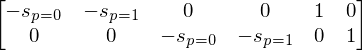

In [10]:
A = zeros(q, q * p)
for row in range(q):
    A[row, row * p:(row + 1) * p] =  -s.T
A = A.row_join(eye(q))
A

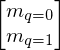

In [11]:
b = m
b

Now we can check to make sure that our new form gives the same answer as the previous form:

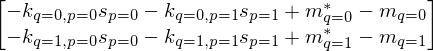

In [12]:
zero2 = A * x - b 
zero2

In [13]:
assert zero == zero2

Now for $n$ time steps in a gait cycle we want to form the $\mathbf{A}$ matrix such that there are different gains for each time step.

In [14]:
gain_matrices = []
control_vectors = []
control_star_vectors = []
sensor_vectors = []
for time_step in range(n):
    gain_matrices.append(Matrix(q, p, lambda i, j:
                                Symbol('k^{}_q={},p={}'.format(time_step, i, j))))
    control_vectors.append(Matrix(q, 1, lambda i, j:
                                  Symbol('m^{}_q={}'.format(time_step, i))))
    control_star_vectors.append(Matrix(q, 1, lambda i, j:
                                       Symbol('m^*{}_q={}'.format(time_step, i))))
    sensor_vectors.append(Matrix(p, 1, lambda i, j:
                                 Symbol('s^{}_p={}'.format(time_step, i))))

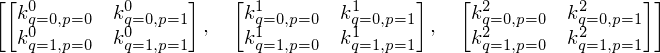

In [15]:
gain_matrices

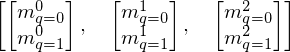

In [16]:
control_vectors

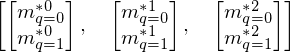

In [17]:
control_star_vectors

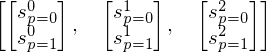

In [18]:
sensor_vectors

Picking off a trio we should get our familiar equation back:

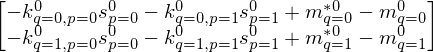

In [19]:
zero = - control_vectors[0] + control_star_vectors[0] - gain_matrices[0] * sensor_vectors[0]
zero

The larger $\mathbf{A}$ matrix for all of the time steps can be formed by stacking the $\mathbf{A}$ matrices from a single time step diagonally:

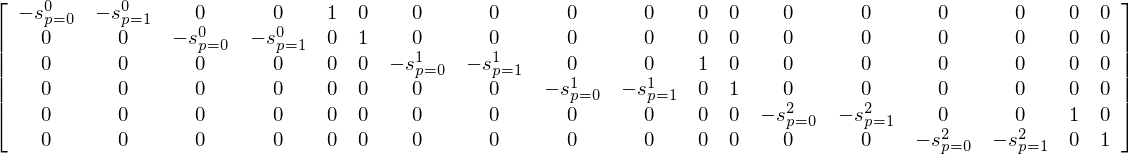

In [20]:
Am = zeros(n * q, n * (q + q * p))
for time_step in range(n):
    An = zeros(q, q * p)
    for row in range(q):
        An[row, row * p:(row + 1) * p] =  -sensor_vectors[time_step].T
    An = An.row_join(eye(q))
    num_rows, num_cols = An.shape
    Am[time_step * num_rows:(time_step + 1) * num_rows, time_step * num_cols:(time_step + 1) * num_cols] = An
Am

The control vector and the gain vector are simple column stacks:

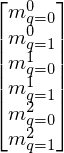

In [21]:
bm = control_vectors[0]
for control in control_vectors[1:]:
    bm = bm.col_join(control)
bm

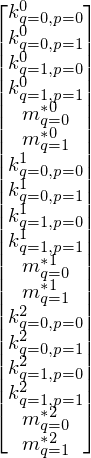

In [22]:
xm = gain_matrices[0].reshape(q * p, 1).col_join(control_star_vectors[0])
for gain, control_star in zip(gain_matrices[1:], control_star_vectors[1:]):
    xm = xm.col_join(gain.reshape(q * p, 1)).col_join(control_star)
xm

Now the original equations can be regenerated with:

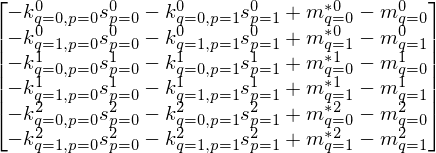

In [23]:
Am * xm - bm

We have $n(p q + q)$ unknowns and $nq$ equations so we need at least $1 + p$ cycles to solve for the unknowns.

In [24]:
n * (p*q + q)

18

In [25]:
1 + p

3

In [26]:
Am.shape, bm.shape

((6, 18), (6, 1))

In [27]:
b = bm
A = Am
for step in range(p):
    b = b.col_join(bm)
    A = A.col_join(Am)

In [28]:
A.shape, b.shape

((18, 18), (18, 1))

In [29]:
%load_ext version_information

In [30]:
%version_information sympy

Software versions
Python 2.7.9 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.0.0
OS Linux 3.13.0 46 generic x86_64 with debian jessie sid
sympy 0.7.6
Fri Mar 06 09:27:07 2015 PST